<a href="https://colab.research.google.com/github/TechKhid/LicensePlateDetection/blob/Still_image_inference/InferenceNumPlate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive 

In [ ]:
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [ ]:
!pip install easyocr

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 62.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.6/47.6 MB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 813.9/813.9 kB 58.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.0/146.0 kB 15.9 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.7.0.72
    Uninstalling opencv-python-headless-4.7.0.72:
      Successfully uninstalled opencv-python-headless-4.7.0.72


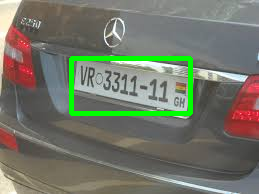

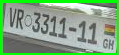

license_number: VR 3311-11


In [54]:
import cv2
import easyocr
import re
import numpy as np 
from google.colab.patches import cv2_imshow


def img_ocr(img, coord_):
  x, y, w, h = coord_[0], coord_[1], coord_[2], coord_[3]
  img = img[y:h, x:w]
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  results = reader.readtext(gray)
  text = ""
  for res in results:
    if len(res) == 1:
      text = res[1]
    if len(res) > 1 and len(res[1]) > 5 and res[2] > 0.2:#9
      text = res[1]
      # text.replace('o', ' ').replace('O', ' ').replace('[', '').replace(']', '')
      
  return text


def convert_string(string):
    parts = string.split("-")
    if len(parts) == 2:
        prefix = parts[0]
        suffix = parts[1][:2]
        return prefix + "-" + suffix
    else:
        return string



reader = easyocr.Reader(['en'], gpu=True)

net = cv2.dnn.readNetFromONNX('/content/gdrive/MyDrive/Colab Notebook/Number Plate Detection/runs/detect/train/weights/best.onnx')
image  =  cv2.imread('/content/gdrive/MyDrive/Colab Notebook/Number Plate Detection/test_files/car2.jpg')





INPUT_WIDTH = 640
INPUT_HEIGHT = 640
SCORE_THRESHOLD = 0.2
NMS_THRESHOLD = 0.4
CONFIDENCE_THRESHOLD = 0.4


CLASESS_YOLO = ['license-plate', 'vehicle']
blob = cv2.dnn.blobFromImage(image, 1/255.0, (INPUT_WIDTH, INPUT_HEIGHT), swapRB=True, crop=False)
net.setInput(blob)
preds = net.forward()
preds = preds.transpose((0, 2, 1))


# Extract output detection
class_ids, confs, boxes = list(), list(), list()

image_height, image_width, _ = image.shape
x_factor = image_width / INPUT_WIDTH
y_factor = image_height / INPUT_HEIGHT

rows = preds[0].shape[0]

for i in range(rows):
    row = preds[0][i]
    conf = row[4]
    
    classes_score = row[4:]
    _,_,_, max_idx = cv2.minMaxLoc(classes_score)
    class_id = max_idx[1]
    if (classes_score[class_id] > .25):
        confs.append(conf)
        label = CLASESS_YOLO[int(class_id)]
        class_ids.append(label)
        
        #extract boxes
        x, y, w, h = row[0].item(), row[1].item(), row[2].item(), row[3].item() 
        left = int((x - 0.5 * w) * x_factor)
        top = int((y - 0.5 * h) * y_factor)
        width = int(w * x_factor)
        height = int(h * y_factor)
        box = np.array([left, top, width, height])
        boxes.append(box)
        
r_class_ids, r_confs, r_boxes = list(), list(), list()

indexes = cv2.dnn.NMSBoxes(boxes, confs, 0.25, 0.45) 
for i in indexes:
    r_class_ids.append(class_ids[i])
    r_confs.append(confs[i])
    r_boxes.append(boxes[i])
for i in indexes:
    box = boxes[i]
    left = box[0]
    top = box[1]
    width = box[2]
    height = box[3]
    xywh = [left, top , left + width, top + height] 
    license = img_ocr(image, xywh)
    cv2.rectangle(image, (left, top), (left + width, top + height), (0,255,0), 3)
    crop = image[top:top + height, left:left + width]




new = license.replace('o', ' ').replace('O', ' ').replace('[', '').replace(']', '')
linc_num = convert_string(new)
cv2_imshow(image)
cv2_imshow(crop)
print(f"license_number: {linc_num}")


# if cv2.waitKey(1) == ord('x'):
#     cv2.destroyAllWindows()
